In [1]:
# tf tools
import tensorflow as tf

# image processsing
from tensorflow.keras.preprocessing.image import (load_img,
                                                  img_to_array,
                                                  ImageDataGenerator)
# VGG16 model
from tensorflow.keras.applications.vgg16 import (preprocess_input,
                                                 decode_predictions,
                                                 VGG16)
# cifar10 data - 32x32
from tensorflow.keras.datasets import cifar10

# layers
from tensorflow.keras.layers import (Flatten, 
                                     Dense, 
                                     Dropout, 
                                     BatchNormalization)
# generic model object
from tensorflow.keras.models import Model

# optimizers
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.optimizers import SGD

#scikit-learn
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report

# for plotting
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

2023-05-15 11:36:23.806910: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-15 11:36:23.862567: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-15 11:36:23.868208: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-15 11:36:24.921161: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
#loading VGG16 without the classification layers and disableling the convolutional layers
model = VGG16()

553467096/553467096 [==============================] - 15s 0us/step


In [6]:
def lables(type):
    df = pd.read_json(f"../../images/metadata/{type}_data.json", lines=True)
    lables = df['class_label']
    unique_classes = lables.unique()
    
    return lables, unique_classes

In [9]:
train_lables = lables("train")[0]
test_lables = lables("test")[0]

In [12]:
# integers to one-hot vectors
lb = LabelBinarizer()
train_lables = lb.fit_transform(train_lables)
test_lables = lb.fit_transform(test_lables)

labelNames = lables("train")[1]
labelNames = labelNames.tolist()

In [49]:
train_data_dir = os.path.join("../../images/")
test_directory = os.path.join("../../images/test/")
batch_size = 32
image_size = (224, 224)  # Adjust the dimensions as per your requirements


In [54]:
train_datagen = ImageDataGenerator(rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2) # set validation split

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(32, 32),
    batch_size=batch_size,
    class_mode='binary',
    subset='training') # set as training data

validation_generator = train_datagen.flow_from_directory(
    train_data_dir, # same directory as training data
    target_size=(32, 32),
    batch_size=batch_size,
    class_mode='binary',
    subset='validation') # set as validation data

model.fit_generator(
    train_generator,
    steps_per_epoch = train_generator.samples // batch_size,
    validation_data = validation_generator, 
    validation_steps = validation_generator.samples // batch_size,
    epochs = 10)

Found 84933 images belonging to 4 classes.
Found 21233 images belonging to 4 classes.


/tmp/ipykernel_949/106328651.py:21: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(


Epoch 1/10


2023-05-15 15:06:14.996610: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


TypeError: 'NoneType' object is not callable

In [56]:
# load model without classifier layers
model = VGG16(include_top=False, 
              pooling='avg',
              input_shape=(32, 32, 3))

# mark loaded layers as not trainable
for layer in model.layers:
    layer.trainable = False

In [57]:
tf.keras.backend.clear_session()
# add new classifier layers
flat1 = Flatten()(model.layers[-1].output)
class1 = Dense(128, activation='relu')(flat1)
output = Dense(10, activation='softmax')(class1)

# define new model
model = Model(inputs=model.inputs, 
              outputs=output)
# summarize
#model.summary()

In [60]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.01,
    decay_steps=10000,
    decay_rate=0.9)
sgd = SGD(learning_rate=lr_schedule)

model.compile(optimizer=sgd,
              loss='sparse_categorical_crossentropy', #https://www.kaggle.com/general/197993
              metrics=['accuracy'])

In [63]:
train_datagen = ImageDataGenerator(rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2) # set validation split

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(32, 32),
    batch_size=batch_size,
    class_mode='binary',
    subset='training') # set as training data

validation_generator = train_datagen.flow_from_directory(
    train_data_dir, # same directory as training data
    target_size=(32, 32),
    batch_size=batch_size,
    class_mode='binary',
    subset='validation') # set as validation data

H = model.fit_generator(
    train_generator,
    steps_per_epoch = train_generator.samples // batch_size,
    validation_data = validation_generator, 
    validation_steps = validation_generator.samples // batch_size,
    epochs = 1)

Found 84933 images belonging to 4 classes.
Found 21233 images belonging to 4 classes.


/tmp/ipykernel_949/2457474137.py:21: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  H = model.fit_generator(
2023-05-15 15:22:39.800141: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


2654/2654 [==============================] - ETA: 0s - loss: 0.5058 - accuracy: 0.8587

2023-05-15 16:42:48.276763: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


2654/2654 [==============================] - 6027s 2s/step - loss: 0.5058 - accuracy: 0.8587 - val_loss: 0.5370 - val_accuracy: 0.8587


In [64]:
def plot_history(H, epochs):
    plt.style.use("seaborn-colorblind")

    plt.figure(figsize=(12,6))
    plt.subplot(1,2,1)
    plt.plot(np.arange(0, epochs), H.history["loss"], label="train_loss")
    plt.plot(np.arange(0, epochs), H.history["val_loss"], label="val_loss", linestyle=":")
    plt.title("Loss curve")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.tight_layout()
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(np.arange(0, epochs), H.history["accuracy"], label="train_acc")
    plt.plot(np.arange(0, epochs), H.history["val_accuracy"], label="val_acc", linestyle=":")
    plt.title("Accuracy curve")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.tight_layout()
    plt.legend()
    plt.show()

/tmp/ipykernel_949/3716877966.py:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-colorblind")


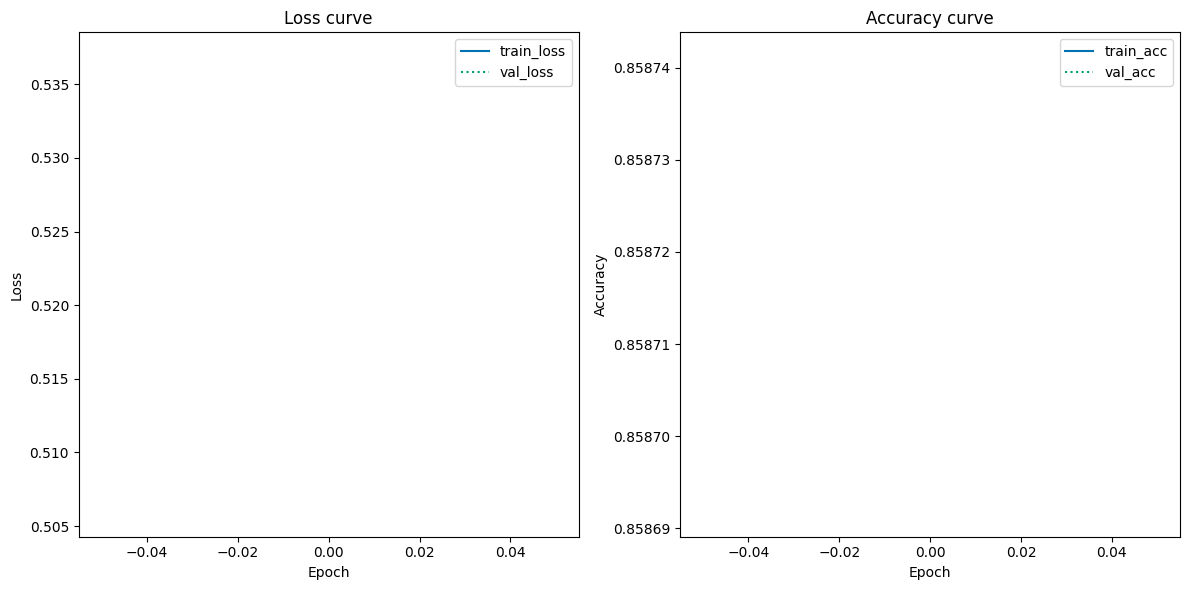

In [66]:
plot_history(H, 1)